In [1]:
import backtrader as bt
import pandas as pd
import os
from price_crawler_minute import build_features
import pickle

## Utility Functions

In [2]:
def get_filename_list(price_data_root='price_data/archive'):
    filename_list = []
    for _, _, filenames in os.walk(os.path.join(os.getcwd(), price_data_root)):
        for filename in filenames:
            if filename.endswith('.csv'):
                filename_list.append(filename)
    return filename_list


# Write my own function for fetching the data from my side to become backtrader acceptable format
def preprocess_price_data_archive(filename, test_size=0.2):
    '''
    This function preprocesses price data dataframe retrieved from the Kaggle and convert it to a backtrader-ready format.
    Input:
        filename <str>: The directory to the specified file.
        test_size <float>: The ratio between train data and test data.
    
    Return:
        train_df <pd.DataFrame>: A preprocessed dataframe for training purpose.
        test_df <pd.DataFrame>: A preprocessed dataframe for testing purpose.
    '''
    # Read and preprocess the data to a backtrader-friendly format
    df = pd.read_csv(filename, usecols=['time', 'open', 'high', 'low', 'close', 'volume'])
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    df.rename(columns={'time': 'datetime'}, inplace=True)
    df = df.set_index('datetime')
    
    # comment this line to disable resampling to perform train test split
    df, _ = build_features(df, ta_list=None, ys=None, roll=0)

    # train test split, but test data are always the latest data
    train_df = df.iloc[:int(len(df) * (1 - test_size))].copy()
    test_df = df.iloc[int(len(df) * (1 - test_size)):].copy()

    return train_df, test_df


def get_model_prediction(model_dir, X):
    with open(model_dir, 'rb') as f:
        model = pickle.load(f)
    return pd.Series(model.predict(X), dtype='int32', index=X.index, name='prediction')


def evaluate_accuracy(x1, x2):
    return (x1 == x2).sum() / len(x1)


class CustomPandasData(bt.feeds.PandasData):
    lines = ('close', 'custom')
    params = (
        ('datetime', None),
        ('open', -1),
        ('high', -1),
        ('low', -1),
        ('close', -1),
        ('volume', -1),
        ('openinterest', None),
        ('custom', 'prediction')
    )


class CustomIndicator(bt.Indicator):
    lines = ('custom',)

    def __init__(self):
        self.lines.custom = self.data.custom


class CustomStrategy(bt.Strategy):
    def __init__(self):
        self.stock_price = self.data.close
        self.custom_indicator = CustomIndicator(subplot=True)

    def notify_order(self, order):
        if order.status == order.Completed:
            if order.isbuy():
                print(f'[{self.data.datetime.date(0)}] {"Buy":>4} @ {order.executed.price:.2f},\tCost: {order.executed.value:.2f},\tCommision: {order.executed.comm:.2f}')
            elif order.issell():
                print(f'[{self.data.datetime.date(0)}] {"Sell":>3} @ {order.executed.price:.2f},\tCost: {order.executed.value:.2f},\tCommision: {order.executed.comm:.2f}')
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            print('Order Canceled/Margin/Rejected')
        self.order = None

    def notify_trade(self, trade):
        if trade.isclosed:
            print(f'Closed a position, Operational Profit, Gross: {trade.pnl:.2f}, Net Profit: {trade.pnlcomm:.2f}')

    def next(self):
        if self.custom_indicator == 1:
            self.order = self.buy()
        elif self.position and self.custom_indicator == 0: # Disabled short selling
            self.order = self.sell()

## Model dumping (Should be done in other scripts beforehand)

In [3]:
# To be inserted into the model generation-side codes.

import pickle
from sklearn.linear_model import LogisticRegression


# For demo purpose
def train_and_dump_model(df, target=['1D-close']):
    X, y = build_features(df, ta_list=None, ys=target, roll=0)

    if len(target) > 1:
        for t in target:
            model = LogisticRegression().fit(X, y[t])
            with open('model.pickle', 'wb') as f: # To be modified about the rules for dumping model names
                pickle.dump(model, f)
                print('Model dumping finished.')
            print('Finished processing', t)
    else:
        model = LogisticRegression().fit(X, y)
        with open('model.pickle', 'wb') as f:
            pickle.dump(model, f)
            print('Model dumping finished.')
        print('Finished processing', target)


price_data_root = 'price_data/archive'
train_df, _ = preprocess_price_data_archive(os.path.join(os.getcwd(), price_data_root, 'ethusd.csv'), test_size=0.2)
train_and_dump_model(train_df)

Model dumping finished.
Finished processing ['1D-close']


## Retrieving Dataset From Source

In [4]:
price_data_root = 'price_data/archive'

# filename_list = get_filename_list(price_data_root=price_data_root)
# for filename in filename_list:
#     df = preprocess_price_data_archive(os.path.join(os.getcwd(), price_data_root, filename))
# #     df = build_ta_features(df, freq='1D', ta_list=None, ys=None)
#     break

train_df, test_df = preprocess_price_data_archive(os.path.join(os.getcwd(), price_data_root, 'ethusd.csv'), test_size=0.2)
x_train, y_train = build_features(train_df, freq='1D', ta_list=None, ys=['1D-close'], roll=0)
x_test, y_test = build_features(test_df, freq='1D', ta_list=None, ys=['1D-close'], roll=0)

y_train_pred = get_model_prediction('model.pickle', x_train)
y_test_pred = get_model_prediction('model.pickle', x_test)

print('Train Accuracy:', evaluate_accuracy(y_train, y_train_pred))
print('Test Accuracy:', evaluate_accuracy(y_test, y_test_pred))

new_df = pd.concat([x_test, y_test_pred], axis=1)
new_df

Train Accuracy: 0.5791447861965492
Test Accuracy: 0.5449101796407185


,open,high,low,close,volume,prediction
datetime,,,,,,
2019-11-02,184.000000,186.87,182.42,183.920000,24547.644374,0
2019-11-03,183.928636,185.45,179.31,182.190000,20881.903583,0
2019-11-04,182.170000,190.10,180.92,187.010000,47604.778814,0
2019-11-05,186.790000,192.80,182.25,189.437072,48150.096929,0
2019-11-06,189.230000,195.21,188.35,191.510000,37272.891772,0
...,...,...,...,...,...,...
2020-09-26,352.615655,357.14,346.46,354.629363,34482.325368,0
2020-09-27,354.912100,363.00,347.60,358.460000,55477.296671,0
2020-09-28,358.560000,368.59,352.71,354.550000,56621.713729,0


## Execution and Simulation

Starting Portfolio Value: 1000.00
[2019-11-22]  Buy @ 162.03,	Cost: 162.03,	Commision: 0.16
[2019-11-23]  Buy @ 150.48,	Cost: 150.48,	Commision: 0.15
[2019-11-24] Sell @ 152.82,	Cost: 156.25,	Commision: 0.15
[2019-11-25]  Buy @ 141.17,	Cost: 141.17,	Commision: 0.14
[2019-11-26] Sell @ 146.78,	Cost: 148.71,	Commision: 0.15
[2019-11-27] Sell @ 148.36,	Cost: 148.71,	Commision: 0.15
Closed a position, Operational Profit, Gross: -5.72, Net Profit: -6.62
[2019-12-17]  Buy @ 133.32,	Cost: 133.32,	Commision: 0.13
[2019-12-18]  Buy @ 122.81,	Cost: 122.81,	Commision: 0.12
[2019-12-19] Sell @ 133.65,	Cost: 128.06,	Commision: 0.13
[2019-12-20]  Buy @ 128.82,	Cost: 128.82,	Commision: 0.13
[2019-12-21] Sell @ 128.93,	Cost: 128.44,	Commision: 0.13
[2019-12-22] Sell @ 127.50,	Cost: 128.44,	Commision: 0.13
Closed a position, Operational Profit, Gross: 5.13, Net Profit: 4.36
[2019-12-24]  Buy @ 128.19,	Cost: 128.19,	Commision: 0.13
[2019-12-25] Sell @ 128.03,	Cost: 128.19,	Commision: 0.13
Closed a posit

<IPython.core.display.Javascript object>


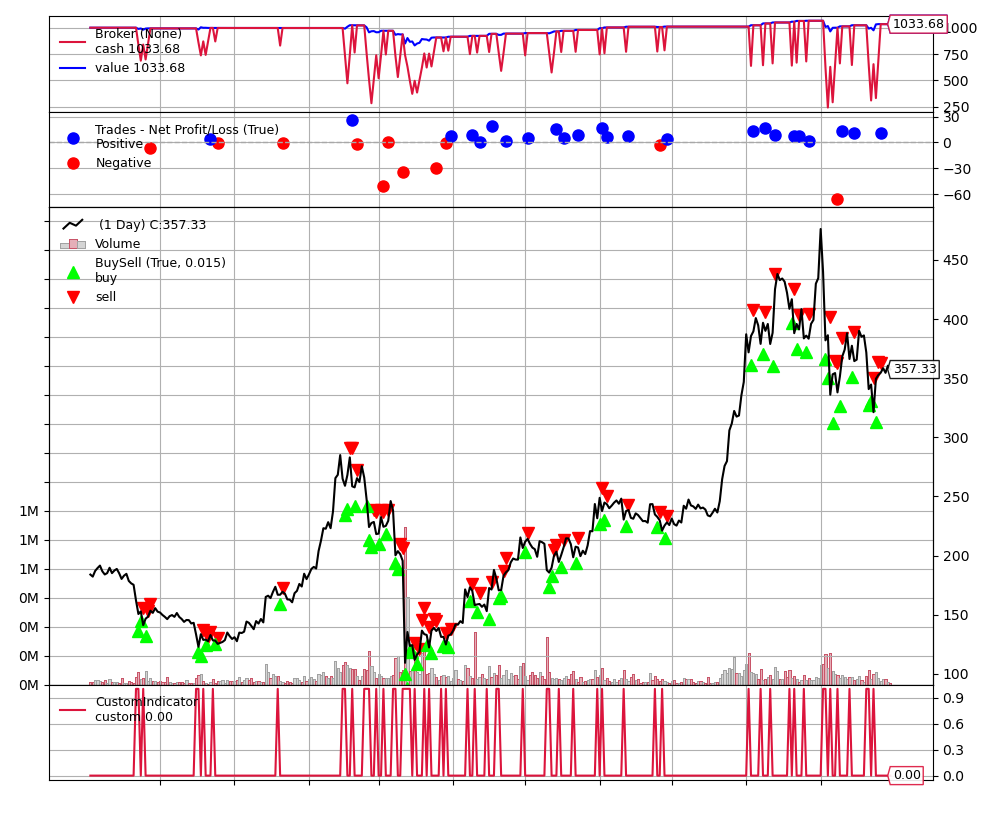

Starting Portfolio Value: 1000.000000
Final Portfolio Value: 1033.681053
PnL: 33.68


In [5]:
cerebro = bt.Cerebro()

cerebro.broker = bt.brokers.BackBroker()
cerebro.broker.setcash(1000)
cerebro.broker.setcommission(commission=0.001)

# Integrate with data source and custom strategies
cerebro.adddata(data=CustomPandasData(dataname=new_df))
cerebro.addstrategy(CustomStrategy)

# Start simulation
start_portfolio_value = cerebro.broker.getvalue()
print(f'Starting Portfolio Value: {start_portfolio_value:.2f}')
cerebro.run()

# Report and Visualization
end_portfolio_value = cerebro.broker.getvalue()
print(f'Final Portfolio Value: {end_portfolio_value:.2f}')
cerebro.plot(volume=True)

pnl = end_portfolio_value - start_portfolio_value
print(f'Starting Portfolio Value: {start_portfolio_value:2f}')
print(f'Final Portfolio Value: {end_portfolio_value:2f}')
print(f'PnL: {pnl:.2f}')